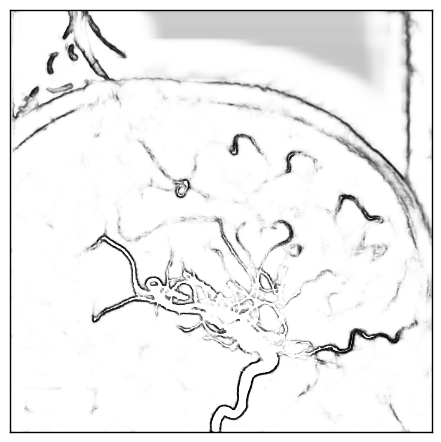

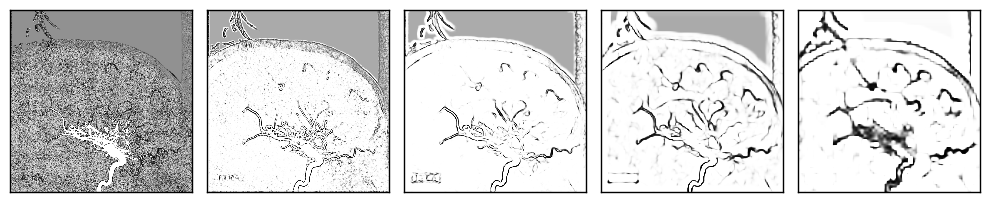

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
%matplotlib inline
import scipy.misc
import PIL
from PIL import Image
import scipy.io
import os
import cv2


# Make sure that caffe is on the python path:
caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples/hed/
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
data_root = '../../data/HED-BSDS/'
with open(data_root+'test.lst') as f:
    test_lst = f.readlines()
    
test_lst = [data_root+x.strip() for x in test_lst]

im_lst = []
for i in range(0, len(test_lst)):
    im = Image.open(test_lst[i])
    in_ = np.array(im, dtype=np.float32)
    in_ = in_[:,:,::-1]
    in_ -= np.array((104.00698793,116.66876762,122.67891434))
    im_lst.append(in_)
    
#Visualization
def plot_single_scale(scale_lst, size):
    pylab.rcParams['figure.figsize'] = size, size/2
    
    plt.figure()
    for i in range(0, len(scale_lst)):
        s=plt.subplot(1,5,i+1)
        plt.imshow(1-scale_lst[i], cmap = cm.binary_r)
        s.set_xticklabels([])
        s.set_yticklabels([])
        s.yaxis.set_ticks_position('none')
        s.xaxis.set_ticks_position('none')
    plt.tight_layout()
    
idx = 2

#in_ = im_lst[idx]
im = cv2.imread('../../data/61bl.png', 0)
#equalize Histogram (equalize on 1024, denoise and dont resize - for best result with equalization)
in_ = cv2.equalizeHist(im)
in_ = cv2.fastNlMeansDenoising(in_,None,10,7,21)
#resize Image (Denoise and resize for good result)
#in_ = cv2.resize(in_, (0, 0), fx=0.25, fy=0.25, interpolation=cv2.INTER_CUBIC)

in_ = np.array(in_, dtype=np.float32)

#gray to RGB
w, h = in_.shape
ret = np.empty((w, h, 3), dtype=np.float32)
ret[:, :, 2] =  ret[:, :, 1] =  ret[:, :, 0] =  in_
in_ = ret

in_ = in_[:,:,::-1]
#in_ -= np.array((104.00698793,116.66876762,122.67891434))
in_ -= np.array((190.00698793,190.66876762,190.67891434))
in_ = in_.transpose((2,0,1))
#remove the following two lines if testing with cpu
#caffe.set_mode_gpu()
#caffe.set_device(0)
# load net
model_root = './'
net = caffe.Net(model_root+'deploy.prototxt', model_root+'hed_pretrained_bsds.caffemodel', caffe.TEST)
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
out1 = net.blobs['sigmoid-dsn1'].data[0][0,:,:]
out2 = net.blobs['sigmoid-dsn2'].data[0][0,:,:]
out3 = net.blobs['sigmoid-dsn3'].data[0][0,:,:]
out4 = net.blobs['sigmoid-dsn4'].data[0][0,:,:]
out5 = net.blobs['sigmoid-dsn5'].data[0][0,:,:]
fuse = net.blobs['sigmoid-fuse'].data[0][0,:,:]

scale_lst = [fuse]
plot_single_scale(scale_lst, 22)
scale_lst = [out1, out2, out3, out4, out5]
plot_single_scale(scale_lst, 10)